In [12]:

### READ RESULTS INTO PANDAS DATAFRAME
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

resultsdir = "../../../ae-results"
# list all directories in resultsdir
configs = ['Baseline.yaml',
            'CoMeT125-3.yaml',
            'CoMeT250-3.yaml',
            'CoMeT500-3.yaml',
            'CoMeT1000-3.yaml',
            'Graphene1000.yaml',
            'Graphene500.yaml',
            'Graphene250.yaml',
            'Graphene125.yaml',
            'Hydra1000.yaml',
            'Hydra500.yaml',
            'Hydra250.yaml',
            'Hydra125.yaml',
            'REGA1000.yaml',
            'REGA500.yaml',
            'REGA250.yaml',
            'REGA125.yaml',
            'PARA1000.yaml',
            'PARA500.yaml',
            'PARA250.yaml',
            'PARA125.yaml',]

# print found configs
print('Found configs: {}'.format(configs))
# list all directories under all configs
workloads = []
for c in configs:
    workloads.append([d for d in os.listdir(os.path.join(resultsdir, c)) if os.path.isdir(os.path.join(resultsdir, c, d))])
# find only the intersection of all workloads
workloads = list(set.intersection(*map(set, workloads)))
# print found workloads
print('Found workloads: {}'.format(workloads))

stats_per_config_workload = []

# for every config + workload directory
for c in configs:
    for w in workloads:
        # find all files in the directory
        files = [f for f in os.listdir(os.path.join(resultsdir, c, w)) if os.path.isfile(os.path.join(resultsdir, c, w, f))]
        # find the stats file
        stat_files = [f for f in files if f.endswith('output.txt')]
        # if there is a stats file
        if stat_files:
            for stat_file in stat_files:
                # if the stats_file has less than three lines skip it
                if len(open(os.path.join(resultsdir, c, w, stat_file)).readlines()) < 3:
                    continue
                
                # print the name of the stats_file
                print('Found stats file: {}'.format(os.path.join(os.path.join(resultsdir, c, w, stat_file))))

                lines = open(os.path.join(resultsdir, c, w, stat_file)).readlines()
                total_energy = 0
                for l in lines:
                    # if line contains nJ, add l.split()[-2] to total_energy
                    if 'Total Idle energy:' in l:
                        continue
                    if 'nJ' in l:
                        total_energy += float(l.split()[-2])

                # create a df with the config, workload and total_energy
                df = pd.DataFrame({'config': [c], 'workload': [w], 'total_energy': [total_energy]})
                df.reset_index(inplace=True, drop=True)
                stats_per_config_workload.append(df)
        else:
            print('Config: {}, Workload: {}, Stats: No stats file found'.format(c, w))

# concatenate all stats into one dataframe
stats = pd.concat(stats_per_config_workload)

# find elements where workload does not contain '-'
# these are multi core workloads
stats = stats[~stats['workload'].str.contains('-')]

# remove these two workloads: stream_10.trace and random_10.trace
stats = stats[~stats['workload'].isin(['stream10_200m.trace', 'random10_200m.trace'])]
# also from workloads
workloads = [w for w in workloads if not w in ['stream10_200m.trace', 'random10_200m.trace']]

# remove "-16DR" from config names
stats['config'] = stats['config'].str.replace('-16DR', '')

# replace 1K with 1000 in config names
stats['config'] = stats['config'].str.replace('1K', '1000')

# replace 'Baseline' with 'Baseline0'
stats['config'] = stats['config'].str.replace('Baseline', 'Baseline0')

# add a new column that stores in integer the number in the config name
stats['nrh'] = stats['config'].str.extract('(\d+)').astype(int)

# remove numbers from config names
stats['config'] = stats['config'].str.replace('\d+', '')
stats['config'] = stats['config'].str.replace('-3', '')

# remove yaml from config names
stats['config'] = stats['config'].str.replace('.yaml', '')

# increasing order of rbmpki
#order = ['511.povray', '481.wrf', '541.leela', '538.imagick', '444.namd', '447.dealII', '464.h264ref', '456.hmmer', '403.gcc', '526.blender', '544.nab', '525.x264', '508.namd', '531.deepsjeng', '458.sjeng', '435.gromacs', '445.gobmk', '401.bzip2', '507.cactuBSSN', '502.gcc', '500.perlbench', '523.xalancbmk', '510.parest', '557.xz', '482.sphinx3', '505.mcf', '436.cactusADM', '471.omnetpp', '473.astar', '483.xalancbmk', '462.libquantum', '433.milc', '520.omnetpp', '437.leslie3d', '450.soplex', '459.GemsFDTD', '549.fotonik3d', '434.zeusmp', '519.lbm', '470.lbm', '429.mcf']
order = ['h264_encode', '511.povray', '481.wrf', '541.leela', '538.imagick', '444.namd', '447.dealII', '464.h264ref', '456.hmmer', '403.gcc', '526.blender', '544.nab', '525.x264', '508.namd', 'grep_map0', '531.deepsjeng', '458.sjeng', '435.gromacs', '445.gobmk', '401.bzip2', '507.cactuBSSN', '502.gcc', 'ycsb_abgsave', 'tpch6', '500.perlbench', '523.xalancbmk', 'ycsb_dserver', 'ycsb_cserver', '510.parest', 'ycsb_bserver', 'ycsb_eserver', 'stream_10.trace', 'tpcc64', 'ycsb_aserver', '557.xz', '482.sphinx3', 'jp2_decode', '505.mcf', 'wc_8443', 'wc_map0', '436.cactusADM', '471.omnetpp', '473.astar', 'jp2_encode', 'tpch17', '483.xalancbmk', '462.libquantum', 'tpch2', '433.milc', '520.omnetpp', '437.leslie3d', '450.soplex', '459.GemsFDTD', '549.fotonik3d', '434.zeusmp', '519.lbm', '470.lbm', '429.mcf', 'random_10.trace', 'h264_decode', 'bfs_ny', 'bfs_cm2003', 'bfs_dblp']

# order workloads according to the order
stats['workload'] = pd.Categorical(stats['workload'], categories=order, ordered=True)

stats_copy = stats.copy()



Found configs: ['Baseline.yaml', 'CoMeT125-3.yaml', 'CoMeT250-3.yaml', 'CoMeT500-3.yaml', 'CoMeT1000-3.yaml', 'Graphene1000.yaml', 'Graphene500.yaml', 'Graphene250.yaml', 'Graphene125.yaml', 'Hydra1000.yaml', 'Hydra500.yaml', 'Hydra250.yaml', 'Hydra125.yaml', 'REGA1000.yaml', 'REGA500.yaml', 'REGA250.yaml', 'REGA125.yaml', 'PARA1000.yaml', 'PARA500.yaml', 'PARA250.yaml', 'PARA125.yaml']
Found workloads: ['433.milc', '483.xalancbmk', 'grep_map0', 'tpcc64', '447.dealII', '525.x264', '436.cactusADM', 'ycsb_abgsave', '464.h264ref', '403.gcc', '444.namd', '502.gcc', 'bfs_cm2003', '544.nab', '523.xalancbmk', '511.povray', '505.mcf', 'jp2_decode', '507.cactuBSSN', '520.omnetpp', 'tpch6', 'ycsb_eserver', 'wc_map0', '445.gobmk', '434.zeusmp', '510.parest', 'bfs_dblp', '482.sphinx3', 'wc_8443', 'h264_decode', 'tpch17', '450.soplex', 'ycsb_cserver', '462.libquantum', '526.blender', '459.GemsFDTD', '471.omnetpp', 'jp2_encode', '519.lbm', '549.fotonik3d', '437.leslie3d', '508.namd', '429.mcf', 'ycs

In [13]:
# print stats configs
print('Stats configs: {}'.format(stats['config'].unique()))

Stats configs: ['Baseline0' 'CoMeT125' 'CoMeT250' 'CoMeT500' 'CoMeT1000' 'Graphene1000'
 'Graphene500' 'Graphene250' 'Graphene125' 'Hydra1000' 'Hydra500'
 'Hydra250' 'Hydra125' 'REGA1000' 'REGA500' 'REGA250' 'REGA125' 'PARA1000'
 'PARA500' 'PARA250' 'PARA125']


In [14]:
stats = stats_copy.copy()
# copy the IPC of the baseline config as to all configs
baseline = stats[stats['config'] == 'Baseline0']
baseline = baseline[['workload', 'total_energy']]
# baseline
baseline.columns = ['workload', 'baseline_energy']
stats = pd.merge(stats, baseline, on='workload')


stats['normalized_energy'] = stats['total_energy'] / stats['baseline_energy']


In [15]:
print(stats_copy['config'].unique())

import re

stats = stats_copy.copy()
# remove -4-512-128 in the config if it exists
stats['config'] = stats['config'].apply(lambda x: re.sub(r'-4-512-128', '', x))

print(stats['config'].unique())

['Baseline0' 'CoMeT125' 'CoMeT250' 'CoMeT500' 'CoMeT1000' 'Graphene1000'
 'Graphene500' 'Graphene250' 'Graphene125' 'Hydra1000' 'Hydra500'
 'Hydra250' 'Hydra125' 'REGA1000' 'REGA500' 'REGA250' 'REGA125' 'PARA1000'
 'PARA500' 'PARA250' 'PARA125']
['Baseline0' 'CoMeT125' 'CoMeT250' 'CoMeT500' 'CoMeT1000' 'Graphene1000'
 'Graphene500' 'Graphene250' 'Graphene125' 'Hydra1000' 'Hydra500'
 'Hydra250' 'Hydra125' 'REGA1000' 'REGA500' 'REGA250' 'REGA125' 'PARA1000'
 'PARA500' 'PARA250' 'PARA125']


      config       workload  total_energy  nrh
0   Baseline       433.milc  2.254410e+07    0
0   Baseline  483.xalancbmk  6.382374e+06    0
0   Baseline      grep_map0  1.058408e+07    0
0   Baseline         tpcc64  6.955596e+06    0
0   Baseline     447.dealII  5.754660e+06    0
..       ...            ...           ...  ...
0       PARA    435.gromacs  5.274957e+06  125
0       PARA    538.imagick  5.567661e+06  125
0       PARA      456.hmmer  6.098832e+06  125
0       PARA      401.bzip2  6.143575e+06  125
0       PARA    h264_encode  5.741995e+06  125

[1281 rows x 4 columns]
      config       workload  total_energy  nrh
0   Baseline       433.milc  2.254410e+07    0
0   Baseline  483.xalancbmk  6.382374e+06    0
0   Baseline      grep_map0  1.058408e+07    0
0   Baseline         tpcc64  6.955596e+06    0
0   Baseline     447.dealII  5.754660e+06    0
..       ...            ...           ...  ...
0   Baseline    435.gromacs  5.246473e+06    0
0   Baseline    538.imagick  5.5675

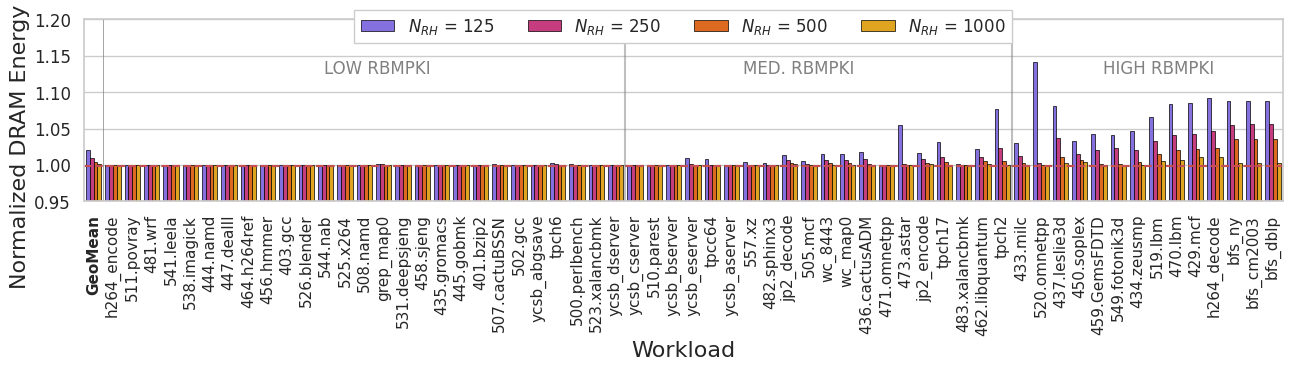

In [16]:
import re
# use seaborn-deep style
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
#sns.set_palette("pastel", n_colors=5)


# sns set color palette '#648FFF',
comet_palette = [ '#785EF0', '#DC267F', '#FE6100', '#FFB000']
sns.set_palette(comet_palette, n_colors=4)

stats = stats_copy.copy()


# remove numbers from config names
stats['config'] = stats['config'].str.replace('\d+', '')
stats['config'] = stats['config'].str.replace('Baseline0', 'Baseline')
stats['config'] = stats['config'].str.replace('1000', '')
stats['config'] = stats['config'].str.replace('500', '')
stats['config'] = stats['config'].str.replace('250', '')
stats['config'] = stats['config'].str.replace('125', '')


print(stats)


# copy the IPC of the baseline config as to all configs
baseline = stats[stats['config'] == 'Baseline']
print(baseline)
baseline = baseline[['workload', 'total_energy']]
# baseline
baseline.columns = ['workload', 'baseline_energy']
print(baseline)
stats = pd.merge(stats, baseline, on='workload')

stats['normalized_energy'] = stats['total_energy'] / stats['baseline_energy']

# normalized ipc for hydra is not correct, so we overwrite it with the correct value
#stats.loc[stats['config'].str.contains('Hydra'), 'normalized_energy'] = stats['total_energy'] / stats['ramulator.hydra_baseline_energy']

# add the geometric normalized ipc average as a new workload to every config
geometric_mean = stats.groupby(['config','nrh'])['normalized_energy'].apply(lambda x: x.prod()**(1.0/len(x))).reset_index()
geometric_mean['workload'] = 'GeoMean'

stats = pd.concat([stats, geometric_mean])

#order = ['GeoMean', '531.deepsjeng', '502.gcc', '541.leela', '435.gromacs', '481.wrf', '458.sjeng', '445.gobmk', '444.namd', '508.namd', '401.bzip2', '456.hmmer', '403.gcc', '464.h264ref', '526.blender', '447.dealII', '544.nab', '523.xalancbmk', '500.perlbench', '538.imagick', '525.x264', '507.cactuBSSN', '511.povray', '462.libquantum', '473.astar', '510.parest', '482.sphinx3', '505.mcf', '557.xz', '471.omnetpp', '483.xalancbmk', '436.cactusADM', '520.omnetpp', '450.soplex', '470.lbm', '519.lbm', '434.zeusmp', '433.milc', '459.GemsFDTD', '549.fotonik3d', '429.mcf', '437.leslie3d']
order = ['GeoMean', 'h264_encode', '511.povray', '481.wrf', '541.leela', '538.imagick', '444.namd', '447.dealII', '464.h264ref', '456.hmmer', '403.gcc', '526.blender', '544.nab', '525.x264', '508.namd', 'grep_map0', '531.deepsjeng', '458.sjeng', '435.gromacs', '445.gobmk', '401.bzip2', '507.cactuBSSN', '502.gcc', 'ycsb_abgsave', 'tpch6', '500.perlbench', '523.xalancbmk', 'ycsb_dserver', 'ycsb_cserver', '510.parest', 'ycsb_bserver', 'ycsb_eserver', 'tpcc64', 'ycsb_aserver', '557.xz', '482.sphinx3', 'jp2_decode', '505.mcf', 'wc_8443', 'wc_map0', '436.cactusADM', '471.omnetpp', '473.astar', 'jp2_encode', 'tpch17', '483.xalancbmk', '462.libquantum', 'tpch2', '433.milc', '520.omnetpp', '437.leslie3d', '450.soplex', '459.GemsFDTD', '549.fotonik3d', '434.zeusmp', '519.lbm', '470.lbm', '429.mcf', 'h264_decode', 'bfs_ny', 'bfs_cm2003', 'bfs_dblp']

# order = ['GeoMean', '511.povray', '481.wrf', '541.leela', '538.imagick', '444.namd', '447.dealII', '464.h264ref', '456.hmmer', '403.gcc', '526.blender', '544.nab', '525.x264', '508.namd', '531.deepsjeng', '458.sjeng', '435.gromacs', '445.gobmk', '401.bzip2', '507.cactuBSSN', '502.gcc', '500.perlbench', '523.xalancbmk', '510.parest', '557.xz', '482.sphinx3', '505.mcf', '436.cactusADM', '471.omnetpp', '473.astar', '483.xalancbmk', '462.libquantum', '433.milc', '520.omnetpp', '437.leslie3d', '450.soplex', '459.GemsFDTD', '549.fotonik3d', '434.zeusmp', '519.lbm', '470.lbm', '429.mcf']

stats['workload'] = pd.Categorical(stats['workload'], categories=order, ordered=True)
#barplot of normalized IPC, also draw edges around bars

fig, ax = plt.subplots(figsize=(13, 4))
ax = sns.barplot(x='workload', y='normalized_energy', hue='nrh', data=stats[(stats['config'] == 'CoMeT')], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Workload')
ax.set_ylabel('Normalized DRAM Energy')
# move ylabel down
ax.yaxis.set_label_coords(-0.045,0.3)
# draw a red line at y = 1.0, label it as baseline IPC
ax.axhline(y=0.999, color='r', linestyle='--')
# write above the red line 'baseline IPC' using the same pastel red color, also draw a box around it
#ax.text(0.5, 0.99, 'baseline DRAM Energy', color='r', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='r', boxstyle='round,pad=0.2'))
#ax.text(0.01, 0.2, 'baseline DRAM energy', color='#e74c3c', transform=ax.transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='r', boxstyle='round,pad=0.2', alpha = 0.95))

# extend the y axis to 1.2
ax.set_ylim(0.95, 1.2)
# color the 5th y tick red
#ax.get_yticklabels()[1].set_color('#e74c3c')
# rotate x axis ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# make axis tick font bigger
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='y', which='major', labelsize=12)

# # draw vertical lines to separate the rowhammer threshold values
ax.axvline(x=27.5, color='grey', linestyle='-', alpha=0.5)
# put text before the line saying "LOW RBMPKI"
ax.text(0.2, 0.7, 'LOW RBMPKI', color='grey', transform=ax.transAxes, fontsize=12)
# put arrow to the left above text
#ax.annotate('', xy=(19.5, 0.97), xytext=(27.5, 0.97), arrowprops=dict(facecolor='grey', shrink=0.01, width=3, headwidth=10, alpha=0.99))
ax.axvline(x=47.5, color='grey', linestyle='-', alpha=0.5)
ax.text(0.55, 0.7, 'MED. RBMPKI', color='grey', transform=ax.transAxes, fontsize=12 )
#ax.annotate('', xy=(39.5, 0.97), xytext=(47.5, 0.97), arrowprops=dict(facecolor='grey', shrink=0.01, width=3, headwidth=10, alpha=0.95))
ax.text(0.85, 0.7, 'HIGH RBMPKI', color='grey', transform=ax.transAxes, fontsize=12 )
#ax.annotate('', xy=(53.5, 0.97), xytext=(61.5, 0.97), arrowprops=dict(facecolor='grey', shrink=0.01, width=3, headwidth=10, alpha=0.95))

# make x and y axis labels bigger
ax.xaxis.label.set_size(16)
#ax.yaxis.label.set_fontweight('bold')
ax.yaxis.label.set_size(16)
#ax.xaxis.label.set_fontweight('bold')

ax.axvline(x=0.5, color='grey', linestyle='-', linewidth=0.5)


# put the legend on top of the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=False, shadow=False, framealpha=1, fontsize=12)
# prepend "nRH" to legend names
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['$N_{RH}$ = ' + label for label in labels], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=False, shadow=False, framealpha=1, fontsize=12)

# highlight the geometric mean ax label
ax.get_xticklabels()[0].set_fontweight('bold')

plt.tight_layout()
plt.show()

# save figure
fig.savefig('comet-singlecore-energy.pdf', bbox_inches='tight')
# export data to csv
stats.to_csv('comet-singlecore-energy.csv', index=False)



In [22]:

# print the number of workloads per config and nrh
#print(stats.groupby(['config', 'nrh'])['workload'].count())
#print the normalized ipc of CMS for the geomean at nrh=1000
print("====\nnRH=1k, CoMeT\'s AVERAGE Energy Overhead (%):")
print(((stats[(stats['config']=='CoMeT') & (stats['nrh']==1000) & (stats['workload']=='GeoMean')]['normalized_energy'])-1)*100)
#print(((stats[(stats['config']=='CoMeT') & (stats['nrh']==1000)]['normalized_energy']).mean()-1)*100)
print("====\nnRH=1k, CoMeT\'s MAX Energy Overhead (%):")
print(((stats[(stats['config']=='CoMeT') & (stats['nrh']==1000)]['normalized_energy'].max())-1)*100)
print("====\nnRH=125, CoMeT\'s AVERAGE Energy Overhead (%):")

print(((stats[(stats['config']=='CoMeT') & (stats['nrh']==125) & (stats['workload']=='GeoMean')]['normalized_energy'])-1)*100)
print("====\nnRH=125, CoMeT\'s MAX Energy Overhead (%):")
print(((stats[(stats['config']=='CoMeT') & (stats['nrh']==125)]['normalized_energy'].max())-1)*100)

====
nRH=1k, CoMeT's AVERAGE Energy Overhead (%):
4    0.087691
Name: normalized_energy, dtype: float64
====
nRH=1k, CoMeT's MAX Energy Overhead (%):
1.137144298415338
====
nRH=125, CoMeT's AVERAGE Energy Overhead (%):
1    2.07473
Name: normalized_energy, dtype: float64
====
nRH=125, CoMeT's MAX Energy Overhead (%):
14.115597619447296


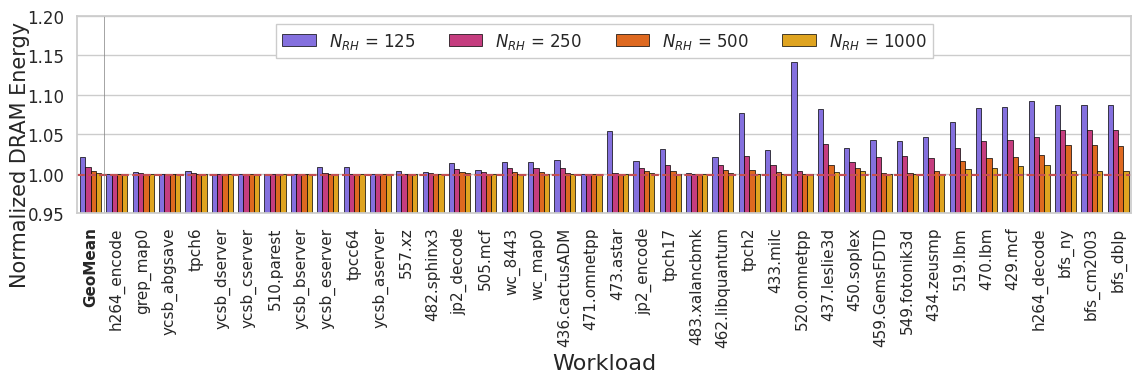

In [23]:
import re
# use seaborn-deep style
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
#sns.set_palette("pastel", n_colors=5)
LOW_RBMPKI = ['531.deepsjeng', '502.gcc', '541.leela', '435.gromacs', '481.wrf', '458.sjeng', '445.gobmk', '444.namd', '508.namd', '401.bzip2', '456.hmmer', '403.gcc', '464.h264ref', '526.blender', '447.dealII', '544.nab', '523.xalancbmk', '500.perlbench', '538.imagick', '525.x264', '507.cactuBSSN', '511.povray']


# sns set color palette '#648FFF',
comet_palette = [ '#785EF0', '#DC267F', '#FE6100', '#FFB000']
sns.set_palette(comet_palette, n_colors=4)

stats = stats_copy.copy()


# remove numbers from config names
stats['config'] = stats['config'].str.replace('\d+', '')
stats['config'] = stats['config'].str.replace('Baseline0', 'Baseline')
stats['config'] = stats['config'].str.replace('1000', '')
stats['config'] = stats['config'].str.replace('500', '')
stats['config'] = stats['config'].str.replace('250', '')
stats['config'] = stats['config'].str.replace('125', '')


#print(stats)


# copy the IPC of the baseline config as to all configs
baseline = stats[stats['config'] == 'Baseline']
#print(baseline)
baseline = baseline[['workload', 'total_energy']]
# baseline
baseline.columns = ['workload', 'baseline_energy']
#print(baseline)
stats = pd.merge(stats, baseline, on='workload')

stats['normalized_energy'] = stats['total_energy'] / stats['baseline_energy']


# add the geometric normalized ipc average as a new workload to every config
geometric_mean = stats.groupby(['config','nrh'])['normalized_energy'].apply(lambda x: x.prod()**(1.0/len(x))).reset_index()
geometric_mean['workload'] = 'GeoMean'

stats = pd.concat([stats, geometric_mean])
stats = stats[~stats['workload'].isin(LOW_RBMPKI)]


#order = ['GeoMean', '531.deepsjeng', '502.gcc', '541.leela', '435.gromacs', '481.wrf', '458.sjeng', '445.gobmk', '444.namd', '508.namd', '401.bzip2', '456.hmmer', '403.gcc', '464.h264ref', '526.blender', '447.dealII', '544.nab', '523.xalancbmk', '500.perlbench', '538.imagick', '525.x264', '507.cactuBSSN', '511.povray', '462.libquantum', '473.astar', '510.parest', '482.sphinx3', '505.mcf', '557.xz', '471.omnetpp', '483.xalancbmk', '436.cactusADM', '520.omnetpp', '450.soplex', '470.lbm', '519.lbm', '434.zeusmp', '433.milc', '459.GemsFDTD', '549.fotonik3d', '429.mcf', '437.leslie3d']
order = ['GeoMean', 'h264_encode', '511.povray', '481.wrf', '541.leela', '538.imagick', '444.namd', '447.dealII', '464.h264ref', '456.hmmer', '403.gcc', '526.blender', '544.nab', '525.x264', '508.namd', 'grep_map0', '531.deepsjeng', '458.sjeng', '435.gromacs', '445.gobmk', '401.bzip2', '507.cactuBSSN', '502.gcc', 'ycsb_abgsave', 'tpch6', '500.perlbench', '523.xalancbmk', 'ycsb_dserver', 'ycsb_cserver', '510.parest', 'ycsb_bserver', 'ycsb_eserver', 'tpcc64', 'ycsb_aserver', '557.xz', '482.sphinx3', 'jp2_decode', '505.mcf', 'wc_8443', 'wc_map0', '436.cactusADM', '471.omnetpp', '473.astar', 'jp2_encode', 'tpch17', '483.xalancbmk', '462.libquantum', 'tpch2', '433.milc', '520.omnetpp', '437.leslie3d', '450.soplex', '459.GemsFDTD', '549.fotonik3d', '434.zeusmp', '519.lbm', '470.lbm', '429.mcf', 'h264_decode', 'bfs_ny', 'bfs_cm2003', 'bfs_dblp']
order = [x for x in order if not (x in LOW_RBMPKI)]

# order = ['GeoMean', '511.povray', '481.wrf', '541.leela', '538.imagick', '444.namd', '447.dealII', '464.h264ref', '456.hmmer', '403.gcc', '526.blender', '544.nab', '525.x264', '508.namd', '531.deepsjeng', '458.sjeng', '435.gromacs', '445.gobmk', '401.bzip2', '507.cactuBSSN', '502.gcc', '500.perlbench', '523.xalancbmk', '510.parest', '557.xz', '482.sphinx3', '505.mcf', '436.cactusADM', '471.omnetpp', '473.astar', '483.xalancbmk', '462.libquantum', '433.milc', '520.omnetpp', '437.leslie3d', '450.soplex', '459.GemsFDTD', '549.fotonik3d', '434.zeusmp', '519.lbm', '470.lbm', '429.mcf']

stats['workload'] = pd.Categorical(stats['workload'], categories=order, ordered=True)
#barplot of normalized IPC, also draw edges around bars

fig, ax = plt.subplots(figsize=(11.5, 4))
ax = sns.barplot(x='workload', y='normalized_energy', hue='nrh', data=stats[(stats['config'] == 'CoMeT')], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Workload')
ax.set_ylabel('Normalized DRAM Energy')
# move ylabel down
ax.yaxis.set_label_coords(-0.045,0.3)
# draw a red line at y = 1.0, label it as baseline IPC
ax.axhline(y=0.999, color='r', linestyle='--')
# write above the red line 'baseline IPC' using the same pastel red color, also draw a box around it
#ax.text(0.5, 0.99, 'baseline DRAM Energy', color='r', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='r', boxstyle='round,pad=0.2'))
#ax.text(0.01, 0.2, 'baseline DRAM energy', color='#e74c3c', transform=ax.transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='r', boxstyle='round,pad=0.2', alpha = 0.95))

# extend the y axis to 1.2
ax.set_ylim(0.95, 1.2)
# color the 5th y tick red
#ax.get_yticklabels()[1].set_color('#e74c3c')
# rotate x axis ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# make axis tick font bigger
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='y', which='major', labelsize=12)

# # draw vertical lines to separate the rowhammer threshold values
#ax.axvline(x=27.5, color='grey', linestyle='-', alpha=0.5)
# put text before the line saying "LOW RBMPKI"
#ax.text(0.2, 0.7, 'LOW RBMPKI', color='grey', transform=ax.transAxes, fontsize=12)
# put arrow to the left above text
#ax.annotate('', xy=(19.5, 0.97), xytext=(27.5, 0.97), arrowprops=dict(facecolor='grey', shrink=0.01, width=3, headwidth=10, alpha=0.99))
#ax.axvline(x=47.5, color='grey', linestyle='-', alpha=0.5)
#ax.text(0.55, 0.7, 'MED. RBMPKI', color='grey', transform=ax.transAxes, fontsize=12 )
#ax.annotate('', xy=(39.5, 0.97), xytext=(47.5, 0.97), arrowprops=dict(facecolor='grey', shrink=0.01, width=3, headwidth=10, alpha=0.95))
#ax.text(0.85, 0.7, 'HIGH RBMPKI', color='grey', transform=ax.transAxes, fontsize=12 )
#ax.annotate('', xy=(53.5, 0.97), xytext=(61.5, 0.97), arrowprops=dict(facecolor='grey', shrink=0.01, width=3, headwidth=10, alpha=0.95))

# make x and y axis labels bigger
ax.xaxis.label.set_size(16)
#ax.yaxis.label.set_fontweight('bold')
ax.yaxis.label.set_size(15)
#ax.xaxis.label.set_fontweight('bold')

ax.axvline(x=0.5, color='grey', linestyle='-', linewidth=0.5)


# put the legend on top of the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=False, shadow=False, framealpha=1, fontsize=12)
# prepend "nRH" to legend names
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['$N_{RH}$ = ' + label for label in labels], loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4, fancybox=False, shadow=False, framealpha=1, fontsize=12)

# highlight the geometric mean ax label
ax.get_xticklabels()[0].set_fontweight('bold')

plt.tight_layout()
plt.show()

# save figure
fig.savefig('comet-singlecore-energy2.pdf', bbox_inches='tight')
# export data to csv
stats.to_csv('comet-singlecore-energy2.csv', index=False)

['CoMeT' 'Graphene' 'Hydra' 'REGA' 'PARA']


/tmp/ipykernel_1503764/4015611813.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_no_baseline['nrh'] = pd.Categorical(stats_no_baseline['nrh'], categories=[1000, 500, 250, 125], ordered=True)
/tmp/ipykernel_1503764/4015611813.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_no_baseline['config'] = pd.Categorical(stats_no_baseline['config'], categories=['Graphene', 'CoMeT', 'Hydra', 'REGA', 'PARA'], ordered=True)


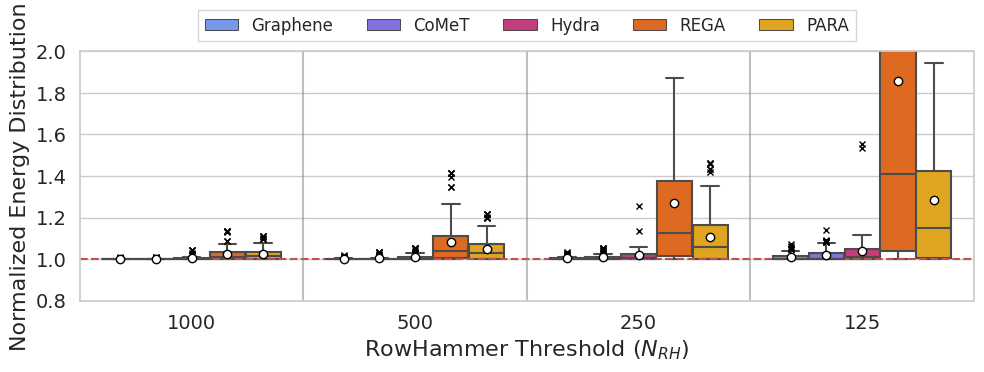

1.024518579527902
nan


In [24]:
# use seaborn-deep style
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
sns.set_palette("pastel", n_colors=5)


# add comet's palette
comet_palette = [ '#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
sns.set_palette(comet_palette, n_colors=5)


#stats = stats_copy.copy()

#stats = stats_copy.copy()
#stats['config'] = stats_copy['config'].apply(lambda x: re.sub(r'-4-512-128', '', x))


# remove numbers from config names
stats = stats_copy.copy()
stats['config'] = stats['config'].str.replace('-4-512-128', '')
stats['config'] = stats['config'].str.replace('Baseline0', 'Baseline')
stats['config'] = stats['config'].str.replace('1000', '')
stats['config'] = stats['config'].str.replace('500', '')
stats['config'] = stats['config'].str.replace('250', '')
stats['config'] = stats['config'].str.replace('125', '')
stats['config'] = stats['config'].str.replace('CMS', 'CoMeT')

# copy the IPC of the baseline config as to all configs
baseline = stats[stats['config'] == 'Baseline']
baseline = baseline[['workload', 'total_energy']]
# baseline
baseline.columns = ['workload', 'baseline_energy']
stats = pd.merge(stats, baseline, on='workload')

#hydra baseline
#hydra_baseline = stats[stats['config'] == 'Hydra-Baseline']
#hydra_baseline = hydra_baseline[['workload', 'total_energy']]
## hydra_baseline
#hydra_baseline.columns = ['workload', 'ramulator.hydra_baseline_energy']
#stats = pd.merge(stats, hydra_baseline, on='workload')

stats['normalized_energy'] = stats['total_energy'] / stats['baseline_energy']

# normalized ipc for hydra is not correct, so we overwrite it with the correct value
#stats.loc[stats['config'].str.contains('Hydra'), 'normalized_energy'] = stats['total_energy'] / stats['ramulator.hydra_baseline_energy']

# new dataframe that does not have the baseline configs
stats_no_baseline = stats[~stats['config'].str.contains('Baseline')]

# new dataframe that does not have the baseline configs
print(stats_no_baseline['config'].unique())

# order nRH from high to low
stats_no_baseline['nrh'] = pd.Categorical(stats_no_baseline['nrh'], categories=[1000, 500, 250, 125], ordered=True)

# order config in this order: SAC, Graphene, Hydra, REGA, PARA
stats_no_baseline['config'] = pd.Categorical(stats_no_baseline['config'], categories=['Graphene', 'CoMeT', 'Hydra', 'REGA', 'PARA'], ordered=True)

#boxplot of normalized IPC
fig, ax = plt.subplots(figsize=(10, 4))
# show mean values as well
ax = sns.boxplot(x="nrh", y="normalized_energy", hue="config", data=stats_no_baseline, showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"},
                  showfliers = True, flierprops={"marker":"x","markerfacecolor":"black", "markeredgecolor":"black"})
ax.set_xlabel('RowHammer Threshold ($N_{RH}$)')
ax.set_ylabel('Normalized Energy Distribution')
# draw a red line at y = 1.0, label it as baseline IPC
ax.axhline(y=1.0, color='r', linestyle='--')
# write above the red line 'baseline IPC'
#ax.text(0.02, 0.05, 'baseline DRAM energy', color='#e74c3c', transform=ax.transAxes, fontsize=15)
# extend the y axis to 1.2
ax.set_ylim(0.8, 2.0)
# color the 5th y tick red
#ax.get_yticklabels()[1].set_color('#e74c3c')
# make axis tick font bigger
ax.tick_params(axis='both', which='major', labelsize=14)
# draw vertical lines to separate the rowhammer threshold values
ax.axvline(x=0.5, color='grey', linestyle='-', alpha=0.5)
ax.axvline(x=1.5, color='grey', linestyle='-', alpha=0.5)
ax.axvline(x=2.5, color='grey', linestyle='-', alpha=0.5)
# make x and y axis labels bigger
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)

# put the legend on top of the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5, fancybox=False, shadow=False, fontsize=12)

plt.tight_layout()
plt.show()

# save figure
fig.savefig('comet-singlecore-energy-comparison.pdf', bbox_inches='tight')
# export data to csv
stats_no_baseline.to_csv('comet-singlecore-energy-comparison.csv', index=False)

# REGA at 1000 nRH normalized_energy for the geomean workload
print(stats_no_baseline[(stats_no_baseline['nrh'] == 1000) & (stats_no_baseline['config'] == 'REGA')]['normalized_energy'].mean())
print(stats_no_baseline[(stats_no_baseline['nrh'] == 1000) & (stats_no_baseline['config'] == 'ABACuS')]['normalized_energy'].mean())

In [29]:
comet_1k= stats_no_baseline[(stats_no_baseline['nrh'] == 1000) & (stats_no_baseline['config'] == 'CoMeT')]['normalized_energy'].mean()
comet_125= stats_no_baseline[(stats_no_baseline['nrh'] == 125) & (stats_no_baseline['config'] == 'CoMeT')]['normalized_energy'].mean()

graphene_1k = stats_no_baseline[(stats_no_baseline['nrh'] == 1000) & (stats_no_baseline['config'] == 'Graphene')]['normalized_energy'].mean()
graphene_125 = stats_no_baseline[(stats_no_baseline['nrh'] == 125) & (stats_no_baseline['config'] == 'Graphene')]['normalized_energy'].mean()

print('Graphene 1k: ', (graphene_1k-1)*100)
print('Graphene 125: ', (graphene_125-1)*100)

print('CoMeT 1k / Graphene 1k: ', ((comet_1k / graphene_1k)-1)*100)
print('CoMeT 125 / Graphene 125: ', ((comet_125 / graphene_125)-1)*100)

rega_1k = stats_no_baseline[(stats_no_baseline['nrh'] == 1000) & (stats_no_baseline['config'] == 'REGA')]['normalized_energy'].mean()
rega_125 = stats_no_baseline[(stats_no_baseline['nrh'] == 125) & (stats_no_baseline['config'] == 'REGA')]['normalized_energy'].mean()

#print('REGA 1k: ', rega_1k)
#print('REGA 125: ', rega_125)

para_1k = stats_no_baseline[(stats_no_baseline['nrh'] == 1000) & (stats_no_baseline['config'] == 'PARA')]['normalized_energy'].mean()
para_125 = stats_no_baseline[(stats_no_baseline['nrh'] == 125) & (stats_no_baseline['config'] == 'PARA')]['normalized_energy'].mean()

#print('PARA 1k: ', para_1k)
#print('PARA 125: ', para_125)

hydra_1k = stats_no_baseline[(stats_no_baseline['nrh'] == 1000) & (stats_no_baseline['config'] == 'Hydra')]['normalized_energy'].mean()
hydra_125 = stats_no_baseline[(stats_no_baseline['nrh'] == 125) & (stats_no_baseline['config'] == 'Hydra')]['normalized_energy'].mean()

print('Hydra 1k: ', (hydra_1k-1)*100)
print('Hydra 125: ', (hydra_125-1)*100)

print('Hydra_1k / CoMeT_1k: ', ((hydra_1k / comet_1k)-1)*100)
print('Hydra_125 / CoMeT_125: ', ((hydra_125 / comet_125)-1)*100)

Graphene 1k:  0.04857871943282355
Graphene 125:  1.1510310985672012
CoMeT 1k / Graphene 1k:  0.03935282850062727
CoMeT 125 / Graphene 125:  0.965415742876985
Hydra 1k:  0.48105045094164467
Hydra 125:  4.050730137608571
Hydra_1k / CoMeT_1k:  0.3927543558401414
Hydra_125 / CoMeT_125:  1.8831068500185788
